## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 7 октября 2020

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 20 октября

Жесткий дедлайн: 23:59MSK 27 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [1]:
import numpy as np
import pandas as pd

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [2]:
data = pd.read_csv('hw-practice-2.data.csv')
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [3]:
data.shape

(48895, 16)

In [4]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [5]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Как видите, в данных есть пропуски. Не забудьте обработать их

In [7]:
data[['name', 'host_name', 'last_review']] = data[['name', 'host_name', 'last_review']].fillna('nan')
data[['reviews_per_month']] = data[['reviews_per_month']].fillna(-1)
assert not data.isna().any().any()

Разобъем данные на обучение и контроль.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
**Сигнатуру методов, классов, функции при желании можно менять.**

In [9]:
from typing import Union, Callable, Iterable, Optional, Dict, Any
from sklearn.neighbors import NearestNeighbors
import scipy
import os


def exp_kernel(d):
    v = np.exp(-d)
    v /= v.mean(axis=1, keepdims=True)
    return v


def normalize_array(v):
    if isinstance(v, pd.DataFrame):
        v = v.values
    elif isinstance(v, scipy.sparse.spmatrix):
        v = np.asarray(v.todense())
    else:
        assert isinstance(v, np.ndarray), type(v)
    return v


class KNNRegressor:
    def __init__(
        self,
        X: np.array, y: np.array,
        n_neighbors: int,
        metric: Union[str, Callable],
        metric_params: Dict[str, Any] = None,
        mode: str = 'uniform',
        distance_kernel: Callable = exp_kernel
    ):
        """
        params:
            X: data
            y: labels
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
              'uniform' - all points in each neighborhood are weighted equally
              'distance' - weight points by the inverse of their distance
        """
        X = normalize_array(X)
        y = normalize_array(y)

        self.__nn = NearestNeighbors(
            n_neighbors=n_neighbors, algorithm='brute',
            metric=metric, metric_params=metric_params,
        )
        self.__nn.fit(X)
        self.__point_values = y
        self.__mode = mode
        self.__distance_kernel = distance_kernel

    def predict(self, X: np.array, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """
        assert self.__mode in {'uniform', 'distance'}
        X = normalize_array(X)
        
        if self.__mode == 'uniform':
            nind = self.__nn.kneighbors(X, n_neighbors, return_distance=False)
            nval = self.__point_values[nind]
        
            return nval.mean(axis=1)
        
        elif self.__mode == 'distance':
            ndis, nind = self.__nn.kneighbors(X, n_neighbors, return_distance=True)
            nval = self.__point_values[nind]
            nwgh = self.__distance_kernel(ndis)
        
            return (nwgh * nval).mean(axis=1)

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках _(в этом задании только на них!)_ , которые обсуждались на [втором семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2020/blob/master/seminars/sem02_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [10]:
# Install semi-native vectorized metrics for sklearn
import sklearn.neighbors
import sklearn.metrics

vbrute = sklearn.neighbors.VALID_METRICS['brute']
vmetrics = sklearn.metrics.pairwise._VALID_METRICS
pairwise = sklearn.metrics.pairwise.PAIRWISE_DISTANCE_FUNCTIONS

def install_metric(f):
    name = f.__name__
    if name not in vbrute:
        vbrute.append(name)
    if name not in vmetrics:
        vmetrics.append(name)

    def _wrap(X, Z, **kwargs):
        res = f(X, Z, **kwargs)
        assert not np.isnan(res).any()
        return res
    
    pairwise[name] = _wrap
    return f

In [11]:
# Helper functions
def take_along_last(sources, indices):
    return np.take_along_axis(sources, indices.T, 1).T

def lists_to_dense(ss):
    s_max = max(s.size for s in ss)
    s_dense = np.full((len(ss), s_max), np.nan)
    for s_idx, s in enumerate(ss):
        s_dense[s_idx, :s.size] = s
    return s_dense

def get_counts(xf):
    uv, uc = np.unique(xf, return_counts=True)
    uv_ints = uv.astype(np.int)
        
    assert uv.min() >= 0 and np.allclose(uv, uv_ints)
    uc_full = np.zeros(1 + uv_ints.max())
    uc_full[uv_ints] = uc
    uc = uc_full
    return uc

In [12]:
# Implement the metrics
@install_metric
def overlap(X, Z, **kwargs):
    X = X[:, np.newaxis]
    Z = Z[np.newaxis, :]
    return (X != Z).sum(axis=2)

@install_metric
def flattened_overlap(X, Z, p2_cums):
    C = take_along_last(p2_cums, X)
    X = X[:, np.newaxis]
    Z = Z[np.newaxis, :]
    matches = X == Z
    misses = ~matches
    return misses.sum(axis=2) + np.einsum('XZF,XF->XZ', matches, C)

@install_metric
def log_overlap(X, Z, f_log):
    CX = take_along_last(f_log, X)
    CZ = take_along_last(f_log, Z)
    X = X[:, np.newaxis]
    Z = Z[np.newaxis, :]
    misses = X != Z
    return np.einsum('XZF,XF,ZF->XZ', misses, CX, CZ)

In [13]:
# Implement the metric fit procedures
def flattened_overlap_fit(x):
    p2_cums = []
    for f in range(x.shape[1]):
        uc = get_counts(x[:, f])

        p = uc/x[:, f].size
        p2 = p * (uc - 1)/(x[:, f].size - 1)

        p_ord = np.argsort(p)
        p2_cum = np.cumsum(p2[p_ord])[np.argsort(p_ord)]
        p2_cums.append(p2_cum)

    return {'p2_cums': lists_to_dense(p2_cums)}

flattened_overlap.fit = flattened_overlap_fit

def log_overlap_fit(x):
    ucs = []
    for f in range(x.shape[1]):
        ucs.append(get_counts(x[:, f]))
    
    return {'f_log': np.log(1 + lists_to_dense(ucs))}

log_overlap.fit = log_overlap_fit

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

> **Категориальные признаки**

In [14]:
import sklearn.preprocessing
import sklearn.metrics

cat_columns = ['room_type', 'neighbourhood_group']
cat_conv = sklearn.preprocessing.OrdinalEncoder(dtype=np.int)
cat_conv.fit(data[cat_columns])

X_train_clsonly = cat_conv.transform(X_train[cat_columns])
X_test_clsonly = cat_conv.transform(X_test[cat_columns])

In [15]:
import time

def timed_eval_rmse(Xtr, ytr, Xte, yte, metric, k=10, mode='uniform'):
    start = time.time()
    
    metric_name = getattr(metric, '__name__', metric)
    metric_params = metric.fit(Xtr) if hasattr(metric, 'fit') else None
    nn = KNNRegressor(
        Xtr, ytr, k,
        metric=metric_name,
        mode=mode,
        metric_params=metric_params
    )
    
    pred = nn.predict(Xte)
    rmse_val = sklearn.metrics.mean_squared_error(yte, pred, squared=False)
    
    delta = time.time() - start
    
    print(f"{metric_name:>17}(k={k:>2}): {rmse_val:.3f} ({delta:.2f}s)")
    return rmse_val

In [16]:
for metric in [
    overlap,
    flattened_overlap,
    log_overlap
]:
    timed_eval_rmse(
        X_train_clsonly, y_train['price'].values,
        X_test_clsonly, y_test['price'].values,
        metric
    )

          overlap(k=10): 216.604 (11.80s)
flattened_overlap(k=10): 210.455 (22.04s)
      log_overlap(k=10): 212.465 (16.14s)


> Функция расстояния `flattened_overlap` показала наилучший результат, так как она больше ценит *редкие совпадения*. Функция `log_overlap` с другой стороны понижает значимость редких совпадений за счет уменьшения расстояния для не совпавших редких классов.

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [17]:
skip = 4
krange = 32
results = {}
for metric in [overlap, flattened_overlap, log_overlap]:
    for k in range(1, krange, skip):
        results[(metric.__name__, k)] = timed_eval_rmse(
            X_train_clsonly, y_train['price'].values,
            X_test_clsonly, y_test['price'].values,
            metric, k=k
        )

          overlap(k= 1): 212.120 (9.65s)
          overlap(k= 5): 233.979 (11.81s)
          overlap(k= 9): 214.748 (11.79s)
          overlap(k=13): 213.812 (11.81s)
          overlap(k=17): 219.382 (11.82s)
          overlap(k=21): 215.691 (11.81s)
          overlap(k=25): 213.605 (11.79s)
          overlap(k=29): 212.056 (11.82s)
flattened_overlap(k= 1): 212.120 (19.69s)
flattened_overlap(k= 5): 211.940 (22.05s)
flattened_overlap(k= 9): 210.183 (22.04s)
flattened_overlap(k=13): 210.288 (22.05s)
flattened_overlap(k=17): 210.034 (22.04s)
flattened_overlap(k=21): 209.662 (22.04s)
flattened_overlap(k=25): 209.484 (22.05s)
flattened_overlap(k=29): 209.282 (22.05s)
      log_overlap(k= 1): 212.120 (13.99s)
      log_overlap(k= 5): 210.504 (16.13s)
      log_overlap(k= 9): 211.752 (16.11s)
      log_overlap(k=13): 211.259 (16.11s)
      log_overlap(k=17): 210.528 (16.12s)
      log_overlap(k=21): 211.064 (16.15s)
      log_overlap(k=25): 210.666 (16.12s)
      log_overlap(k=29): 210.559 (1

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
def adjust_plot(figsize=(1, 1), dpi=1):
    plt.rcParams['figure.dpi'] = 72 * dpi
    plt.rcParams['figure.figsize'] = [v*a/dpi for v, a in zip([6.4, 4.8], figsize)]

In [19]:
compares = np.full((3, krange//skip), np.nan)
morder = ['overlap', 'flattened_overlap', 'log_overlap']
for (m, k), v in results.items():
    compares[morder.index(m), (k-1)//skip] = v

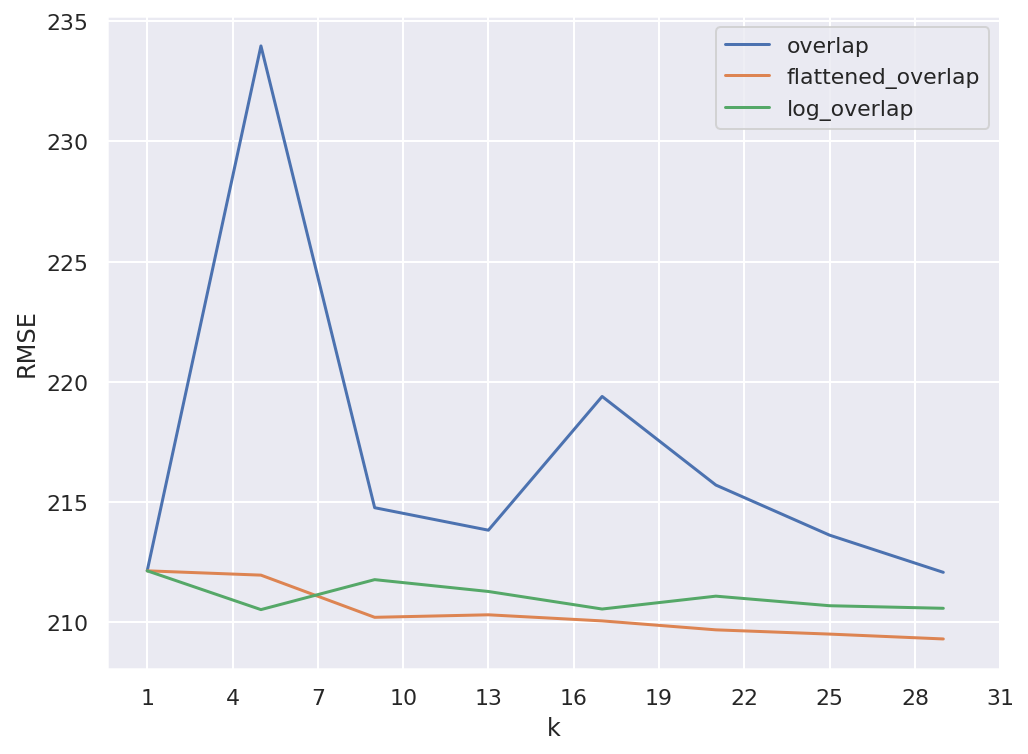

In [20]:
adjust_plot((2.5, 2.5), dpi=2)
for m, c in zip(morder, compares):
    plt.plot(np.arange(1, krange, skip), c, label=m)
plt.xticks(np.arange(1, krange, 3))
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [21]:
for m, c in zip(morder, compares):
    print(f"best k for {m}: {1 + skip*c.argmin()}")

best k for overlap: 29
best k for flattened_overlap: 29
best k for log_overlap: 5


<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [22]:
mean_price = data.price.mean()
y_train['target'] = y_train.price > mean_price
y_test['target'] = y_test.price > mean_price

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [23]:
def counters(x, x_stat):
    counts = np.empty_like(x)
    
    for f in range(x.shape[1]):
        uc = get_counts(x_stat[:, f])
        counts[:,f] = uc[x[:, f]]

    return counts


def smooth_success_rate(x, y_stat, x_stat=None, a=1, b=2):
    if x_stat is None:
        x_stat = x
    
    successes = counters(x, x_stat[y_stat])
    counts = counters(x, x_stat)
    return (successes + a)/(counts + b)

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [24]:
def fold_encode(x, y, n_folds=3, random_state=241, **kwargs):
    rates = np.empty_like(x, dtype=np.float)
    folds = np.random.default_rng(random_state).permutation(x.shape[0])
    folds = np.array_split(folds, n_folds)
    inv_folds = [np.concatenate(folds[:i] + folds[1+i:]) for i in range(n_folds)]
    
    for fold, inv_fold in zip(folds, inv_folds):
        rates[fold] = smooth_success_rate(x[fold], y[inv_fold], x[inv_fold], **kwargs)
    return rates

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

> **Признаки на основании статистик целевого признака (категориальные)**

In [25]:
X_train_clsonly_counters = fold_encode(X_train_clsonly, y_train['target'].values)
X_train_clsonly_counters_no_fold = smooth_success_rate(X_train_clsonly, y_train['target'].values)
X_test_clsonly_counters = smooth_success_rate(X_test_clsonly, y_train['target'].values, X_train_clsonly)

In [26]:
def timed_eval_auroc(Xtr, ytr, Xte, yte, k=10, mode='uniform'):
    start = time.time()
    
    nn = KNNRegressor(Xtr, ytr, k, metric='euclidean', mode=mode)
    pred = nn.predict(Xte)
    roc_auc_val = sklearn.metrics.roc_auc_score(yte, pred)
    
    delta = time.time() - start
    
    print(f"euclidean(k={k:>2}): {roc_auc_val:.3f} ({delta:.2f}s)")
    return roc_auc_val

In [27]:
print('no folds', end=' ')
timed_eval_auroc(
    X_train_clsonly_counters_no_fold, y_train['target'].values,
    X_test_clsonly_counters, y_test['target'].values,
)
print('w/ folds', end=' ')
timed_eval_auroc(
    X_train_clsonly_counters, y_train['target'].values,
    X_test_clsonly_counters, y_test['target'].values,
);

no folds euclidean(k=10): 0.791 (5.09s)
w/ folds euclidean(k=10): 0.823 (5.68s)


> Как видно, вычисление статистик с использованием фолдов увеличивает точность.

In [28]:
skip = 4
krange = 32
results = np.full((krange//skip), np.nan)
for k in range(1, krange, skip):
    results[(k-1)//skip] = timed_eval_auroc(
        X_train_clsonly_counters, y_train['target'].values,
        X_test_clsonly_counters, y_test['target'].values,
        k=k
    )

euclidean(k= 1): 0.729 (3.05s)
euclidean(k= 5): 0.761 (5.68s)
euclidean(k= 9): 0.792 (5.69s)
euclidean(k=13): 0.792 (5.69s)
euclidean(k=17): 0.762 (5.69s)
euclidean(k=21): 0.827 (5.68s)
euclidean(k=25): 0.797 (5.68s)
euclidean(k=29): 0.828 (5.68s)


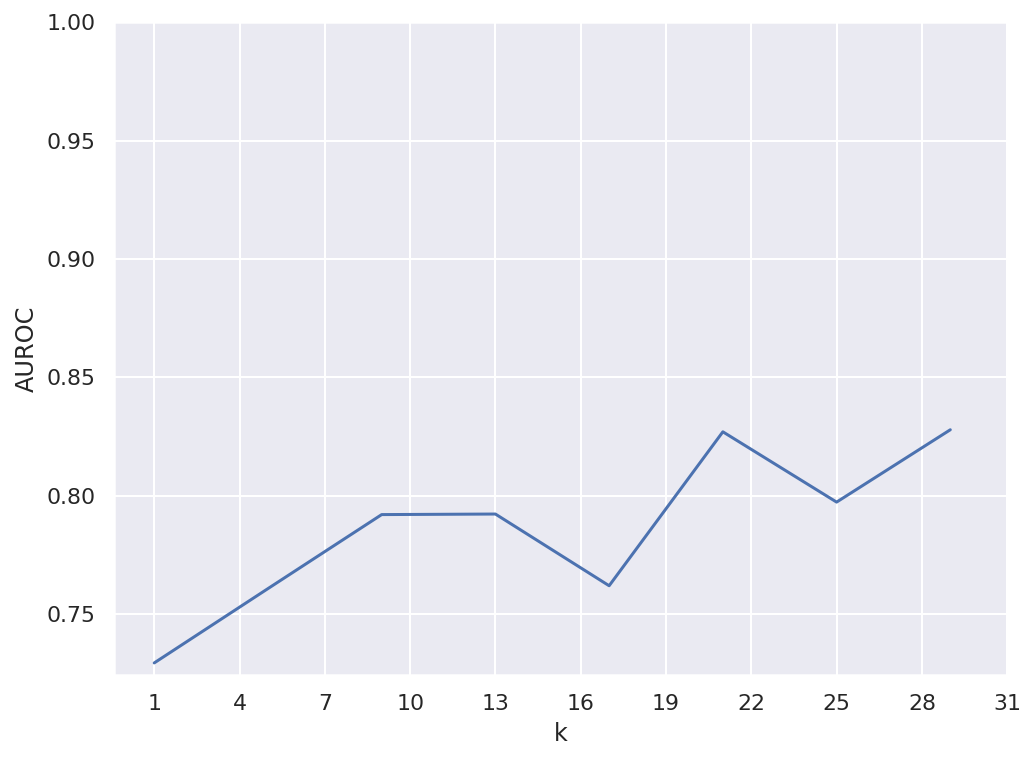

In [29]:
adjust_plot((2.5, 2.5), dpi=2)
plt.plot(np.arange(1, krange, skip), results)
plt.xticks(np.arange(1, krange, 3))
plt.xlabel('k')
plt.ylabel('AUROC')
plt.ylim(None, 1)
plt.show()

In [30]:
print(f"best k for euclidean: {1 + skip*results.argmax()}")

best k for euclidean: 29


<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [31]:
def get_stats(xf, y, fun):
    st_full = np.zeros(1 + xf.max())
    for i in range(st_full.size):
        st_full[i] = fun(y[xf == i])
    return st_full


def stats_encode(x, y_stat, x_stat=None, fun=np.mean):
    if x_stat is None:
        x_stat = x

    encoded = np.empty_like(x, dtype=np.float)
    for f in range(x.shape[1]):
        stats = get_stats(x_stat[:, f], y_stat, fun)
        encoded[:, f] = stats[x[:, f]]
    return encoded

> **Признаки на основании статистик целевого признака (численные)**

In [32]:
X_train_clsonly_mean = stats_encode(X_train_clsonly, y_train['price'].values)
X_test_clsonly_mean = stats_encode(X_test_clsonly, y_train['price'].values, X_train_clsonly)

X_train_clsonly_std = stats_encode(X_train_clsonly, y_train['price'].values, fun=np.std)
X_test_clsonly_std = stats_encode(X_test_clsonly, y_train['price'].values, X_train_clsonly, fun=np.std)

In [33]:
print('mean', end=' ')
timed_eval_rmse(
    X_train_clsonly_mean, y_train['price'].values,
    X_test_clsonly_mean, y_test['price'].values,
    metric='euclidean'
)
print('std ', end=' ')
timed_eval_rmse(
    X_train_clsonly_std, y_train['price'].values,
    X_test_clsonly_std, y_test['price'].values,
    metric='euclidean'
);

mean         euclidean(k=10): 214.788 (5.35s)
std          euclidean(k=10): 218.607 (5.59s)


> Значение RMSE лучше для функции $g = \mathrm{mean}$, потому что среднее значение цены является лучшим предиктором цены, чем среднеквадратичное отклонение цены.

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов). Можно использовать использовать, например, библиотеку nltk.

In [34]:
import sklearn.feature_extraction.text
import nltk
import re

text_columns = ['name']

nltk.download('stopwords')
tok = re.compile(r"(?u)\b\w\w+\b").findall

# Remove stopwords
swords = {sklearn.feature_extraction.text.strip_accents_unicode(s) for s in nltk.corpus.stopwords.words()}
# Normalize
swords = {s.lower() for s in swords}
while (ntoks := {t for w in swords for t in tok(w)}) - swords:
    swords |= ntoks

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> **Текстовые признаки**

In [35]:
bow_conv = sklearn.feature_extraction.text.CountVectorizer(stop_words=swords, strip_accents='unicode', min_df=0.01)
bow_conv.fit(data[text_columns].squeeze(1))
tfidf_conv = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=swords, strip_accents='unicode', min_df=0.01)
tfidf_conv.fit(data[text_columns].squeeze(1))

X_train_bow = bow_conv.transform(X_train[text_columns].squeeze(1))
X_test_bow = bow_conv.transform(X_test[text_columns].squeeze(1))
X_train_tfidf = tfidf_conv.transform(X_train[text_columns].squeeze(1))
X_test_tfidf = tfidf_conv.transform(X_test[text_columns].squeeze(1))

In [36]:
bow_words = bow_conv.get_feature_names()
assert bow_words == tfidf_conv.get_feature_names()
print(len(bow_words), 'words:', ' '.join(bow_words))

87 words: 1br 2br amazing apartment apt astoria balcony bath bathroom beautiful bed bedroom best big br bright brooklyn brownstone bushwick central charming chelsea city clean close comfortable comfy cozy duplex east entire floor garden gorgeous great greenpoint harlem heart heights hill home house huge jfk kitchen large location loft lovely luxury manhattan midtown mins modern near new nyc park perfect place prime private prospect quiet renovated room side slope soho space spacious square studio subway suite sunny times townhouse train two upper view views village west williamsburg york


> Обратим внимание, что можно получить значительный прирост по точности, убрав фильтрацию по минимальной частоте (`min_df`). К сожалению, это приводит к значительному увеличению количества слов в словаре и как следствие, вычислительных затрат. Данный недостаток можно обойти, используя sparse матрицы напрямую (закомментировать строчки с normalize_array в KNNRegressor). Однако в таком случае, полученные sparse признаки нельзя будет использовать совместно с другими dense признаками в последнем задании.

In [37]:
for metric in ['euclidean', 'cosine']:
    print('bow  ', end=' ')
    timed_eval_rmse(
        X_train_bow, y_train['price'].values,
        X_test_bow, y_test['price'].values,
        metric=metric
    )
    print('tfidf', end=' ')
    timed_eval_rmse(
        X_train_tfidf, y_train['price'].values,
        X_test_tfidf, y_test['price'].values,
        metric=metric
    );

bow           euclidean(k=10): 227.600 (39.28s)
tfidf         euclidean(k=10): 225.057 (39.08s)
bow              cosine(k=10): 218.234 (40.67s)
tfidf            cosine(k=10): 224.047 (40.65s)


> Видно, что для Bag of Words и TF-IDF лучше использовать косинусную меру. В данной конфигурации Bag of Words работает лучше чем TF-IDF, однако TF-IDF работает лучше, когда размер словаря значительно больше. Как описано в предыдущем комментарии, я решил не использовать большой словарь, так что Bag of Words с косинусной мере в данной ситуации оказывается лучшим вариантом.

In [38]:
skip = 4
krange = 32
results = {}
for metric in ['euclidean', 'cosine']:
    for name, dataset in [
        ('bow', (X_train_bow, X_test_bow)),
        ('tfidf', (X_train_tfidf, X_test_tfidf)),
    ]:
        for k in range(1, krange, skip):
            results[(name, metric, k)] = timed_eval_rmse(
                dataset[0], y_train['price'].values,
                dataset[1], y_test['price'].values,
                metric, k=k
            )

        euclidean(k= 1): 247.737 (38.80s)
        euclidean(k= 5): 238.668 (39.24s)
        euclidean(k= 9): 229.755 (39.25s)
        euclidean(k=13): 223.348 (39.25s)
        euclidean(k=17): 220.591 (39.22s)
        euclidean(k=21): 217.639 (39.25s)
        euclidean(k=25): 216.947 (39.25s)
        euclidean(k=29): 215.984 (39.24s)
        euclidean(k= 1): 267.290 (39.24s)
        euclidean(k= 5): 234.755 (39.47s)
        euclidean(k= 9): 227.168 (39.49s)
        euclidean(k=13): 221.042 (39.50s)
        euclidean(k=17): 218.143 (39.48s)
        euclidean(k=21): 216.969 (39.51s)
        euclidean(k=25): 215.732 (39.51s)
        euclidean(k=29): 214.876 (39.49s)
           cosine(k= 1): 264.661 (38.55s)
           cosine(k= 5): 225.418 (40.68s)
           cosine(k= 9): 219.618 (40.64s)
           cosine(k=13): 216.451 (40.63s)
           cosine(k=17): 215.753 (40.70s)
           cosine(k=21): 214.644 (40.61s)
           cosine(k=25): 214.833 (40.69s)
           cosine(k=29): 213.931 (

In [39]:
compares = np.full((4, krange//skip), np.nan)
morder = [
    'euclidean bow',
    'euclidean tfidf',
    'cosine bow',
    'cosine tfidf',
]
for (n, m, k), v in results.items():
    compares[morder.index(m + ' ' + n), (k-1)//skip] = v

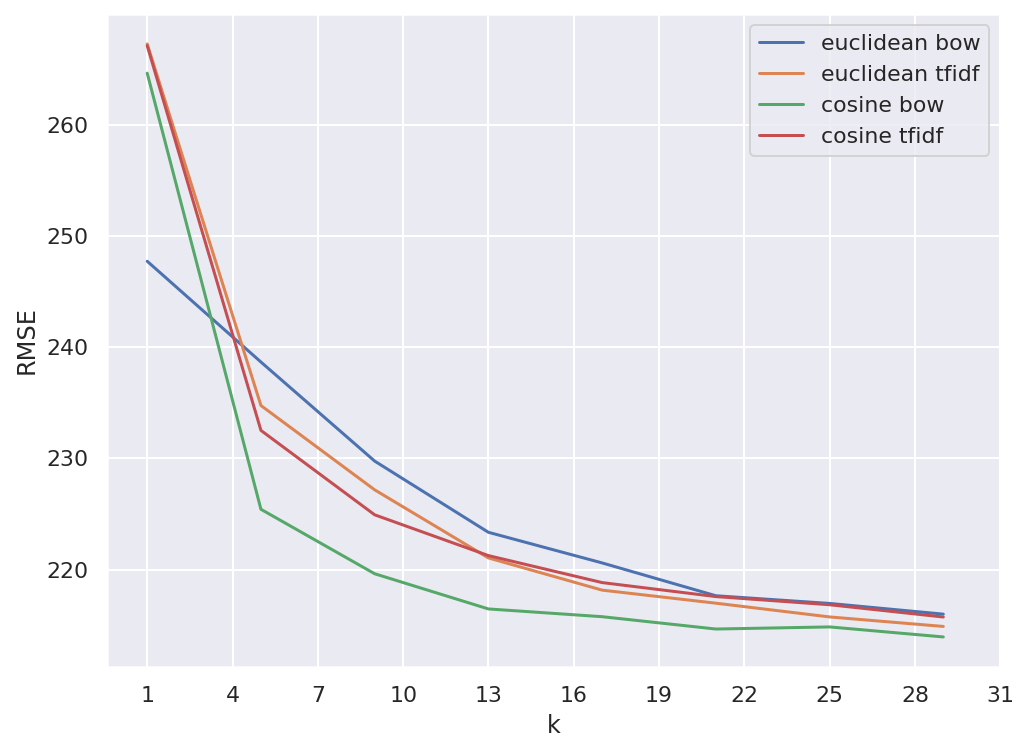

In [40]:
adjust_plot((2.5, 2.5), dpi=2)
for m, c in zip(morder, compares):
    plt.plot(np.arange(1, krange, skip), c, label=m)
plt.xticks(np.arange(1, krange, 3))
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [41]:
for m, c in zip(morder, compares):
    print(f"best k for {m}: {1 + skip*c.argmin()}")

best k for euclidean bow: 29
best k for euclidean tfidf: 29
best k for cosine bow: 29
best k for cosine tfidf: 29


<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования (из сделанных раннее заданий). Повлияло ли добавление количественного признака на метрику качества?

> **Признаки географического положения**

In [42]:
loc_columns = ['latitude', 'longitude']

X_train_loc = X_train[loc_columns].values
X_test_loc = X_test[loc_columns].values

In [43]:
timed_eval_rmse(
    X_train_loc, y_train['price'].values,
    X_test_loc, y_test['price'].values,
    metric='haversine'
);

        haversine(k=10): 222.536 (39.09s)


> **Количественные признаки**

In [44]:
quantity_columns = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']

quantity_conv = sklearn.preprocessing.StandardScaler()
quantity_conv.fit(data[quantity_columns])

X_train_quantity = quantity_conv.transform(X_train[quantity_columns])
X_test_quantity = quantity_conv.transform(X_test[quantity_columns])

In [45]:
timed_eval_rmse(
    X_train_quantity, y_train['price'].values,
    X_test_quantity, y_test['price'].values,
    metric='euclidean'
);

        euclidean(k=10): 226.677 (7.20s)


> **Мультиметрика (все признаки вместе)**

In [46]:
def pack_data(data):
    dtype = np.dtype([
        ('d' + str(idx), x.dtype, (x.shape[1],))
        for idx, x in enumerate(data)
    ])
    
    sz = data[0].shape[0]
    assert all(sz == x.shape[0] for x in data)
    packed = np.empty((sz), dtype=dtype)
    
    for k, x in zip(dtype.fields, data):
        packed[k] = normalize_array(x)
    
    return packed[:, np.newaxis]

def unpack_data(x, idx):
    return x['d' + str(idx)].squeeze(axis=1)

@install_metric
def multi_metric(x, z, metric_spec):
    distance = np.zeros((x.shape[0], z.shape[0]))

    for idx, (metric, mul, kwargs) in enumerate(metric_spec):
        feature_dists = sklearn.metrics.pairwise_distances(
            unpack_data(x, idx), unpack_data(z, idx),
            metric=metric, **kwargs
        )
        distance += mul * feature_dists
    
    return distance

In [47]:
all_metrics = [
    (flattened_overlap, 0.7042),
    ('cosine', 1.071052),
    ('haversine', 11.715),
    ('euclidean', 0.5068),
]
X_train_all = [
    X_train_clsonly,
    X_train_bow,
    X_train_loc,
    X_train_quantity,
]
X_test_all = [
    X_test_clsonly,
    X_test_bow,
    X_test_loc,
    X_test_quantity,
]

In [48]:
def describe_metric(fit_data, fun, dist_mul=None):
    metric_name = getattr(fun, '__name__', fun)
    fit_data = normalize_array(fit_data)
    kwargs = fun.fit(fit_data) if hasattr(fun, 'fit') else {}

    if dist_mul is None:
        # Roughly normalize all metrics to the same scale
        mean_dist = sklearn.metrics.pairwise_distances(
            fit_data, fit_data,
            metric=metric_name, **kwargs
        ).mean()
        dist_mul = 1/mean_dist
        print(f"Normalizing {metric_name} with multiplier {dist_mul:.6f}")
    
    return metric_name, dist_mul, kwargs


def timed_eval_multi_metric_rmse(Xtr, ytr, Xte, yte, metrics, k=10, mode='uniform'):
    start = time.time()
    
    metric_params = {'metric_spec': [
        describe_metric(xfit, m, d) for xfit, (m, d) in zip(Xtr, metrics)
    ]}
    nn = KNNRegressor(
        pack_data(Xtr), ytr, k,
        metric='multi_metric',
        mode=mode,
        metric_params=metric_params,
    )
    
    pred = nn.predict(pack_data(Xte))
    rmse_val = sklearn.metrics.mean_squared_error(yte, pred, squared=False)
    
    delta = time.time() - start
    
    print(f"{'multi_metric':>17}(k={k:>2}): {rmse_val:.3f} ({delta:.2f}s)")
    return rmse_val

In [49]:
print('no quantity', end=' ')
timed_eval_multi_metric_rmse(
    X_train_all[:-1], y_train['price'].values,
    X_test_all[:-1], y_test['price'].values,
    metrics=all_metrics[:-1],
)
print('w/ quantity', end=' ')
timed_eval_multi_metric_rmse(
    X_train_all, y_train['price'].values,
    X_test_all, y_test['price'].values,
    metrics=all_metrics,
);

no quantity multi_metric(k=10): 213.333 (100.41s)
w/ quantity multi_metric(k=10): 209.228 (106.59s)


> Видно, что добавление количественных признаков значительно повлияло на качество.

## Часть 4: Выводы


> Рассмотрим следующую "модель" (тривиальное, константное решение):

In [50]:
start = time.time()

model = y_train['price'].values.mean()

y_true = y_test['price'].values
y_pred = np.ones_like(y_true) * model
rmse_val = sklearn.metrics.mean_squared_error(y_true, y_pred, squared=False)

delta = time.time() - start

print(f"{'constant':>17}({model:.2f}): {rmse_val:.3f} ({delta:.2f}s)")

         constant(153.75): 220.081 (0.00s)


> Обратим внимание, что некоторые выше рассмотренные kNN методы выдают результаты **хуже** тривиального константного предсказания, а лучшая kNN модель дает результат всего на 5% лучше тривиального предсказания.
> 
> На основании данного наблюдения я делаю вывод, что реализация kNN модели и подбор для нее метрик и параметров было огромной тратой моего времени и cpu time (шучу).

In [51]:
cat_oh_conv = sklearn.preprocessing.OneHotEncoder()
cat_oh_conv.fit(data[cat_columns])

X_train_oh_clsonly = cat_oh_conv.transform(X_train[cat_columns])
X_test_oh_clsonly = cat_oh_conv.transform(X_test[cat_columns])

X_train_all_svr = np.concatenate([
    normalize_array(x) for x in [
        X_train_oh_clsonly,
        X_train_loc,
        X_train_quantity,
    ]
], axis=1)
X_test_all_svr = np.concatenate([
    normalize_array(x) for x in [
        X_test_oh_clsonly,
        X_test_loc,
        X_test_quantity,
    ]
], axis=1)

> Но все равно, мне кажется, что ручной подбор гиперпараметров для unsupervised методов – субоптимальная стратегия для решения подобных задач. Чтобы подкрепить мое мнение, я за несколько минут реализовал простенький пайплайн с SVR регрессией, который демонстрирует результаты лучше, чем kNN модели.

In [52]:
import sklearn.pipeline
import sklearn.svm
import sklearn.model_selection

start = time.time()

model = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.svm.SVR(C=3000, epsilon=32, gamma=0.5, cache_size=2**24),
)
model.fit(X_train_all_svr, y_train['price'].values)

delta = time.time() - start

print(f"fit finished in {delta:.2f}s")

fit finished in 115.41s


In [53]:
start = time.time()

y_pred = model.predict(X_test_all_svr)
rmse_val = sklearn.metrics.mean_squared_error(y_test['price'].values, y_pred, squared=False)

delta = time.time() - start

print(f"{'regression':>17}({'SVR':>4}): {rmse_val:.3f} ({delta:.2f}s)")

       regression( SVR): 204.332 (3.80s)
